In [47]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Contents

* [Executive Summary](#Executive-Summary)
* [Base Model (Without SAE)](#Base-Model-(Without-SAE)
* [High Frequency (Without SAE)](#High-Frequency-(Without-SAE)
* [Base Model (With SAE)](#Base-Model-(With-SAE)
* [High Frequency (With SAE)](#High-Frequency-(With-SAE)

# Executive Summary

Spiral 3 is the attempt to replicate the previous CPU based linear classifiers on a GPU using a single layer Neural Network. The NN architecutre parameters were picked as:
- epoch=8. Any higher value leads to overfitting.
- batch_size=1000. This gives the highest accuracy for computation speed. 

The test score of each model is given below using 5 fold CV:

| Model | No SAE | SAE |
|------|------|------|
|   Base Model  | 59.31% | 60.58% |
|   High Frequency  | 73.65% | 43.16% |

On the high frequency model with SAE, most of the 3 classes were being identified as FBFM1. This caused the model to have an accuracy of 43.16% . Altering the batch_size or epoch did not benefit the accuracy. This is strage as the CPU based high frequency model of Spiral 2b achieved an accuracy of 72%. If we are unable to fix the issue, the future Spirals will be run without SAE.

# Without SAE

In [1]:
import sys, os, random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras.backend.tensorflow_backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
%matplotlib inline

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## Prepare fc1000 engineered images

In [2]:
root = "~/WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/"

image_features = pd.read_csv(root+"WIFIRE_fc1000_engineered_features.csv",  delimiter=',', header=None)
df = pd.read_csv(root+'WIFIRE_labels.csv')
labels = df.Labels.values

In [3]:
image_features = normalize(image_features.values) #convert df to np array

In [4]:
np.shape(image_features)

(437153, 1000)

## Base Model (Without SAE)

Prepare image features and labels for modelling

In [5]:
X = image_features
Y = labels

In [6]:
#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
#Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=0)

The following function creates and compiles the NN architecture on the GPU

In [8]:
def baseline_model(device = 1):
    #Shut down tensorflow after use
    with K.tf.device('/gpu:'+str(device)):
        #Create model
        model = Sequential()
        model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1], 
                        kernel_initializer='normal', activation='relu'))
        model.add(Dense(len(np.unique(Y)), 
                        kernel_initializer='normal', activation='sigmoid'))
        
        #Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
        return model

KerasClassifier is an sklearn wrapper for our baseline_model

In [9]:
kc = KerasClassifier(build_fn=baseline_model, 
                            epochs=1, batch_size=1000, verbose=2)

parameters =  {'epochs':(8,)}
        
               
classifier = GridSearchCV(kc, parameters, cv=5)
classifier.fit(X_train, y_train)

Epoch 1/8
5s - loss: 1.2974 - acc: 0.5435
Epoch 2/8
3s - loss: 1.1730 - acc: 0.5768
Epoch 3/8
3s - loss: 1.1528 - acc: 0.5838
Epoch 4/8
3s - loss: 1.1394 - acc: 0.5882
Epoch 5/8
3s - loss: 1.1307 - acc: 0.5899
Epoch 6/8
3s - loss: 1.1224 - acc: 0.5925
Epoch 7/8
3s - loss: 1.1151 - acc: 0.5951
Epoch 8/8
3s - loss: 1.1087 - acc: 0.5964
Epoch 1/8
3s - loss: 1.2939 - acc: 0.5382
Epoch 2/8
3s - loss: 1.1736 - acc: 0.5769
Epoch 3/8
3s - loss: 1.1541 - acc: 0.5823
Epoch 4/8
3s - loss: 1.1411 - acc: 0.5868
Epoch 5/8
3s - loss: 1.1316 - acc: 0.5895
Epoch 6/8
3s - loss: 1.1232 - acc: 0.5918
Epoch 7/8
3s - loss: 1.1163 - acc: 0.5937
Epoch 8/8
3s - loss: 1.1103 - acc: 0.5952
Epoch 1/8
3s - loss: 1.3029 - acc: 0.5406
Epoch 2/8
3s - loss: 1.1754 - acc: 0.5772
Epoch 3/8
3s - loss: 1.1553 - acc: 0.5824
Epoch 4/8
3s - loss: 1.1418 - acc: 0.5870
Epoch 5/8
3s - loss: 1.1326 - acc: 0.5894
Epoch 6/8
3s - loss: 1.1223 - acc: 0.5932
Epoch 7/8
3s - loss: 1.1157 - acc: 0.5949
Epoch 8/8
3s - loss: 1.1093 - acc:

GridSearchCV(cv=5, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb931bf7358>,
       fit_params={}, iid=True, n_jobs=1, param_grid={'epochs': (8,)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [10]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [11]:
conf_arr = confusion_matrix(np.argmax(y_test, axis=1), predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

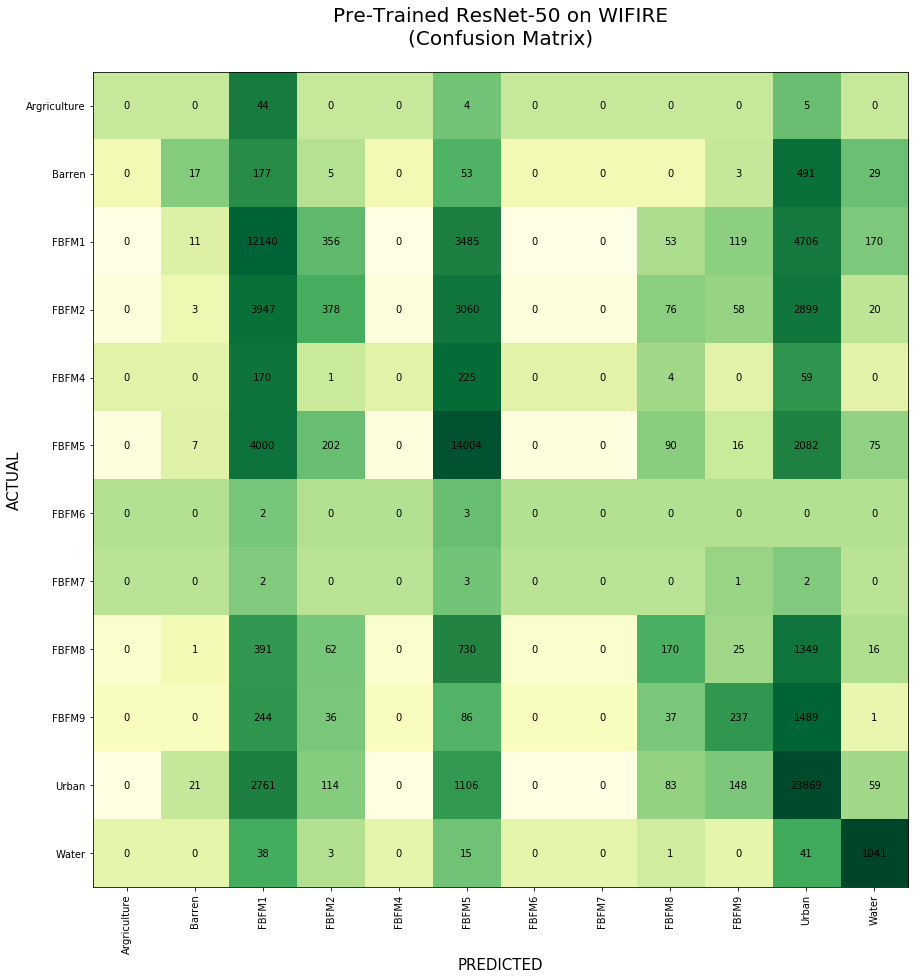

In [12]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(Y)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

In [13]:
((np.sum([np.argmax(y_test, axis=1) == predict_target])*1.0)/(len(y_test)*1.0))*100

59.310770779243057

## High Frequency (Without SAE)

Prepare image features and labels for modelling

In [14]:
high_dist_class_list = ['FBFM1','FBFM5','Urban']
df_high_class = df[df.Labels.isin(high_dist_class_list)]
high_class_idx = np.array(df_high_class.index)

In [15]:
X = image_features[high_class_idx]
Y = labels[high_class_idx]

In [16]:
#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
#Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=0)

The following function creates and compiles the NN architecture on the GPU

In [18]:
def baseline_model(device = 1):
    #Shut down tensorflow after use
    with K.tf.device('/gpu:'+str(device)):
        #Create model
        model = Sequential()
        model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1], 
                        kernel_initializer='normal', activation='relu'))
        model.add(Dense(len(np.unique(Y)), 
                        kernel_initializer='normal', activation='sigmoid'))
        
        #Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
        return model

KerasClassifier is an sklearn wrapper for our baseline_model

In [19]:
kc = KerasClassifier(build_fn=baseline_model, 
                            epochs=1, batch_size=1000, verbose=2)

parameters =  {'epochs':(8,)}
        
               
classifier = GridSearchCV(kc, parameters, cv=5)
classifier.fit(X_train, y_train)

Epoch 1/8
2s - loss: 0.7233 - acc: 0.6932
Epoch 2/8
2s - loss: 0.6738 - acc: 0.7156
Epoch 3/8
2s - loss: 0.6596 - acc: 0.7223
Epoch 4/8
2s - loss: 0.6506 - acc: 0.7264
Epoch 5/8
2s - loss: 0.6436 - acc: 0.7297
Epoch 6/8
2s - loss: 0.6374 - acc: 0.7329
Epoch 7/8
2s - loss: 0.6318 - acc: 0.7350
Epoch 8/8
2s - loss: 0.6272 - acc: 0.7381
Epoch 1/8
2s - loss: 0.7242 - acc: 0.6916
Epoch 2/8
2s - loss: 0.6743 - acc: 0.7147
Epoch 3/8
2s - loss: 0.6604 - acc: 0.7218
Epoch 4/8
2s - loss: 0.6520 - acc: 0.7258
Epoch 5/8
2s - loss: 0.6449 - acc: 0.7287
Epoch 6/8
2s - loss: 0.6386 - acc: 0.7318
Epoch 7/8
2s - loss: 0.6330 - acc: 0.7346
Epoch 8/8
2s - loss: 0.6288 - acc: 0.7374
Epoch 1/8
2s - loss: 0.7247 - acc: 0.6918
Epoch 2/8
2s - loss: 0.6729 - acc: 0.7161
Epoch 3/8
2s - loss: 0.6588 - acc: 0.7231
Epoch 4/8
2s - loss: 0.6499 - acc: 0.7276
Epoch 5/8
2s - loss: 0.6420 - acc: 0.7307
Epoch 6/8
2s - loss: 0.6366 - acc: 0.7331
Epoch 7/8
2s - loss: 0.6321 - acc: 0.7345
Epoch 8/8
2s - loss: 0.6268 - acc:

GridSearchCV(cv=5, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb92fec1668>,
       fit_params={}, iid=True, n_jobs=1, param_grid={'epochs': (8,)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [20]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [21]:
conf_arr = confusion_matrix(np.argmax(y_test, axis=1), predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

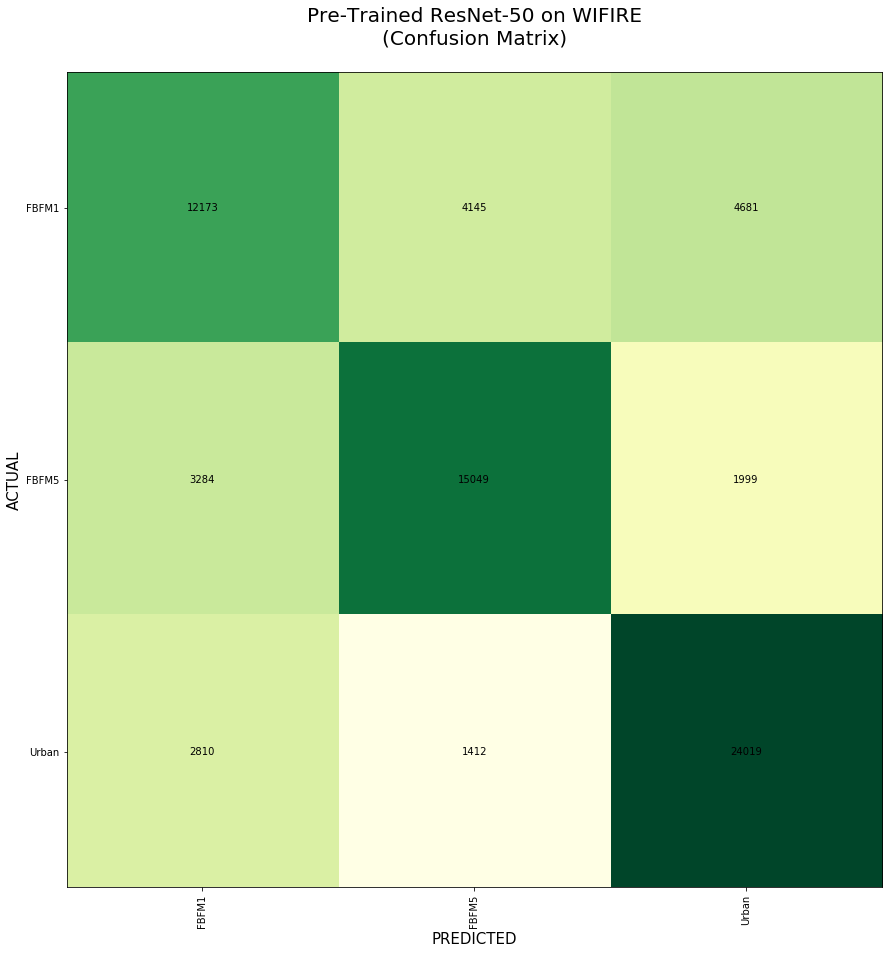

In [22]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(Y)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

In [23]:
((np.sum([np.argmax(y_test, axis=1) == predict_target])*1.0)/(len(y_test)*1.0))*100

73.651756453745762

# With SAE

## Prepare fc1000 engineered images

In [24]:
root = "~/WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/"

image_features = pd.read_csv(root+"WIFIRE_fc1000_engineered_features.csv",  delimiter=',', header=None)
df = pd.read_csv(root+'WIFIRE_labels.csv')
labels = df.Labels.values

In [25]:
df_extras = pd.DataFrame.from_csv("~/WIFIRE/WIFIRE_labels_ElevAspectSlope.csv")[["Slope_WM","Aspect_WM","Elev_WM"]].reset_index( drop=True)
df_extras.head()

,Slope_WM,Aspect_WM,Elev_WM
0,9.925750,79.746309,165.550253
1,11.804788,71.184017,171.092049
2,2.385194,83.726426,118.241052
3,17.021817,81.384949,129.447622
4,1.075829,0.000000,116.848341


In [26]:
image_features = image_features.merge(df_extras,right_index=True, left_index=True).values

In [27]:
print (image_features.shape)

(437153, 1003)


## Base Model (With SAE)

Prepare image features and labels for modelling

In [28]:
X = image_features
Y = labels

In [29]:
#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
#Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=0)

The following function creates and compiles the NN architecture on the GPU

In [31]:
def baseline_model(device = 1):
    #Shut down tensorflow after use
    with K.tf.device('/gpu:'+str(device)):
        #Create model
        model = Sequential()
        model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1], 
                        kernel_initializer='normal', activation='relu'))
        model.add(Dense(len(np.unique(Y)), 
                        kernel_initializer='normal', activation='sigmoid'))
        
        #Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
        return model

KerasClassifier is an sklearn wrapper for our baseline_model

In [32]:
kc = KerasClassifier(build_fn=baseline_model, 
                            epochs=1, batch_size=1000, verbose=2)

parameters =  {'epochs':(8,)}
        
               
classifier = GridSearchCV(kc, parameters, cv=5)
classifier.fit(X_train, y_train)

Epoch 1/8
3s - loss: 1.8282 - acc: 0.2387
Epoch 2/8
3s - loss: 1.7903 - acc: 0.2393
Epoch 3/8
3s - loss: 1.7387 - acc: 0.2391
Epoch 4/8
3s - loss: 1.6280 - acc: 0.2386
Epoch 5/8
3s - loss: 1.5739 - acc: 0.2325
Epoch 6/8
3s - loss: 1.3062 - acc: 0.4720
Epoch 7/8
3s - loss: 1.0997 - acc: 0.5923
Epoch 8/8
3s - loss: 1.0640 - acc: 0.6010
Epoch 1/8
3s - loss: 1.6942 - acc: 0.2355
Epoch 2/8
3s - loss: 1.5879 - acc: 0.2304
Epoch 3/8
3s - loss: 1.5247 - acc: 0.2067
Epoch 4/8
3s - loss: 1.4560 - acc: 0.3168
Epoch 5/8
3s - loss: 1.2837 - acc: 0.3695
Epoch 6/8
3s - loss: 1.2199 - acc: 0.3732
Epoch 7/8
3s - loss: 1.0796 - acc: 0.5943
Epoch 8/8
3s - loss: 1.0479 - acc: 0.6012
Epoch 1/8
3s - loss: 1.5812 - acc: 0.3671
Epoch 2/8
3s - loss: 1.3863 - acc: 0.3573
Epoch 3/8
3s - loss: 1.3214 - acc: 0.3401
Epoch 4/8
3s - loss: 1.2770 - acc: 0.3349
Epoch 5/8
3s - loss: 1.2453 - acc: 0.3318
Epoch 6/8
3s - loss: 1.2216 - acc: 0.3311
Epoch 7/8
3s - loss: 1.2146 - acc: 0.3342
Epoch 8/8
3s - loss: 1.1982 - acc:

GridSearchCV(cv=5, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb8e850c860>,
       fit_params={}, iid=True, n_jobs=1, param_grid={'epochs': (8,)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [33]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [34]:
conf_arr = confusion_matrix(np.argmax(y_test, axis=1), predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

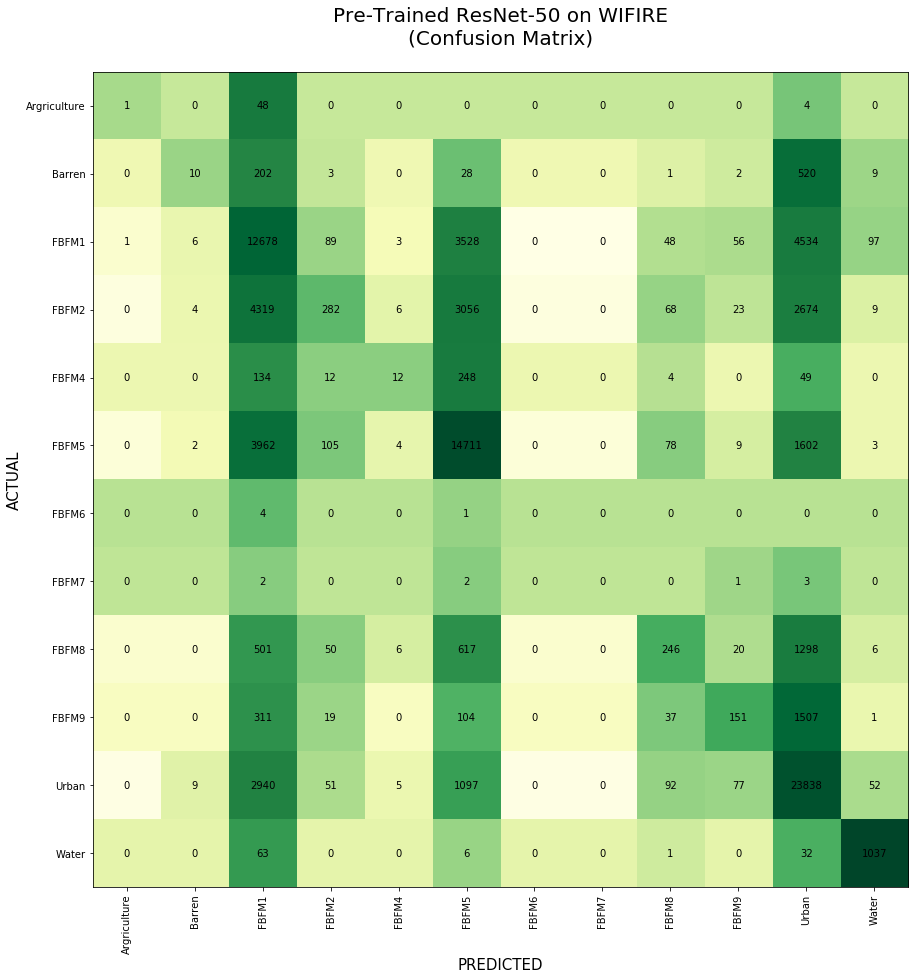

In [35]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(Y)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

In [36]:
((np.sum([np.argmax(y_test, axis=1) == predict_target])*1.0)/(len(y_test)*1.0))*100

60.580343356475396

## High Frequency (With SAE)

In [37]:
high_dist_class_list = ['FBFM1','FBFM5','Urban']
df_high_class = df[df.Labels.isin(high_dist_class_list)]
high_class_idx = np.array(df_high_class.index)

In [38]:
X = image_features[high_class_idx]
Y = labels[high_class_idx]

In [39]:
#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
#Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=0)

The following function creates and compiles the NN architecture on the GPU

In [41]:
def baseline_model(device = 1):
    #Shut down tensorflow after use
    with K.tf.device('/gpu:'+str(device)):
        #Create model
        model = Sequential()
        model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1], 
                        kernel_initializer='normal', activation='relu'))
        model.add(Dense(len(np.unique(Y)), 
                        kernel_initializer='normal', activation='sigmoid'))
        
        #Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
        return model

KerasClassifier is an sklearn wrapper for our baseline_model

In [49]:
kc = KerasClassifier(build_fn=baseline_model, 
                            epochs=1, batch_size=1000, verbose=2)

parameters =  {'epochs':(8,)}
        
               
classifier = GridSearchCV(kc, parameters, cv=5)
classifier.fit(X_train, y_train)

Epoch 1/8
3s - loss: 1.0230 - acc: 0.3019
Epoch 2/8
2s - loss: 0.9962 - acc: 0.3009
Epoch 3/8
2s - loss: 0.9818 - acc: 0.3009
Epoch 4/8
2s - loss: 0.9765 - acc: 0.3009
Epoch 5/8
2s - loss: 0.9694 - acc: 0.3009
Epoch 6/8
2s - loss: 0.9712 - acc: 0.3009
Epoch 7/8
2s - loss: 0.9591 - acc: 0.3009
Epoch 8/8
2s - loss: 0.9531 - acc: 0.3009
Epoch 1/8
3s - loss: 1.0524 - acc: 0.3020
Epoch 2/8
2s - loss: 1.0167 - acc: 0.3009
Epoch 3/8
2s - loss: 0.9898 - acc: 0.3009
Epoch 4/8
2s - loss: 0.9809 - acc: 0.3009
Epoch 5/8
2s - loss: 0.9727 - acc: 0.3009
Epoch 6/8
2s - loss: 0.9698 - acc: 0.3009
Epoch 7/8
2s - loss: 0.9649 - acc: 0.3009
Epoch 8/8
2s - loss: 0.9579 - acc: 0.3009
Epoch 1/8
3s - loss: 1.0230 - acc: 0.4752
Epoch 2/8
2s - loss: 0.9421 - acc: 0.6041
Epoch 3/8
2s - loss: 0.8846 - acc: 0.6020
Epoch 4/8
2s - loss: 0.8523 - acc: 0.5463
Epoch 5/8
2s - loss: 0.8268 - acc: 0.4891
Epoch 6/8
2s - loss: 0.8075 - acc: 0.4459
Epoch 7/8
2s - loss: 0.7962 - acc: 0.4373
Epoch 8/8
2s - loss: 0.7887 - acc:

GridSearchCV(cv=5, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb9349a8320>,
       fit_params={}, iid=True, n_jobs=1, param_grid={'epochs': (8,)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [50]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [51]:
conf_arr = confusion_matrix(np.argmax(y_test, axis=1), predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

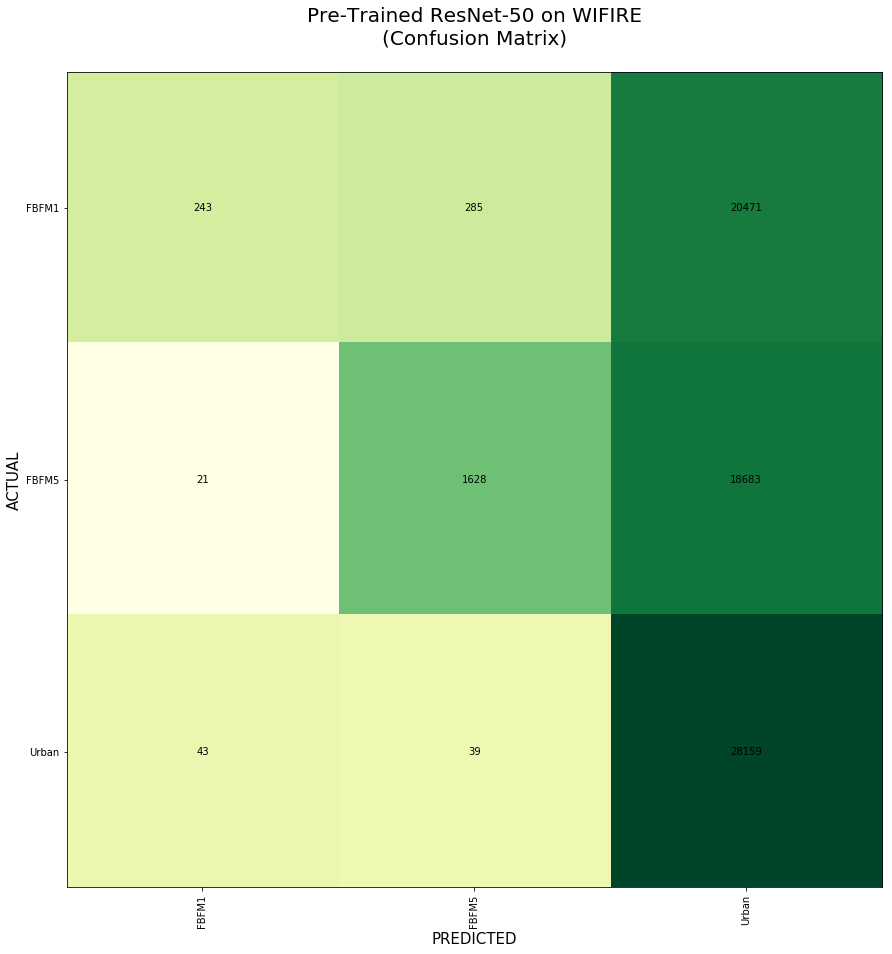

In [52]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(Y)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

In [53]:
((np.sum([np.argmax(y_test, axis=1) == predict_target])*1.0)/(len(y_test)*1.0))*100

43.16391651813948